# Group Project - AI for Security

**Members:**
- Andrea Ferrazzano - andrea1.ferrazzano@mail.polimi.it - 10703279
- Marco Gorini - marco2.gorini@mail.polimi.it - 10710545
- Leonardo Saveri - leonardo.saveri@mail.polimi.it - 10745545
- Claudia Pierpaoli - claudia.pierpaoli@mail.polimi.it - 11016822

# Objective:
In this section of the project, we train non linear classifiers and will evaluate:

## Imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import time
from sklearn.metrics import (
    accuracy_score, 
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    roc_auc_score
)
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate

# Preparing the data

In [2]:
df_train = pd.read_csv("data/df_train.csv")
df_test = pd.read_csv("data/df_test.csv")

print(df_train.shape)
df_test.shape

(106461, 37)


(30613, 37)

In [3]:
df_train.columns

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'SSH', 'TCP',
       'UDP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT',
       'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight',
       'label', 'category_label'],
      dtype='object')

In [4]:
X_train = df_train.drop(columns=["label", "category_label"])
X_test = df_test.drop(columns=["label", "category_label"])

y_train = df_train["category_label"]
y_test = df_test["category_label"]

Now we are scaling values in the train and the test set (everything in this case, because there are only numerical features) to have better performances and predictions.

In [5]:
standard_scaler = StandardScaler().fit(X_train)

X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

Let's save the standars scaler also for the future

In [6]:
#dump(standard_scaler, "scalers/standard_scaler.bin", compress=True)

In [7]:
X_train

array([[-0.35783634, -0.38945825, -0.96776639, ..., -0.34611033,
        -1.22351325, -0.00148732],
       [-0.35783634, -0.38941128, -0.52971559, ..., -0.34611033,
        -1.22351325, -0.00148732],
       [-0.35756658, -0.38939812, -0.52971559, ..., -0.34611033,
        -1.22351325, -0.00148732],
       ...,
       [-0.24805674, -0.38403351, -0.43334441, ..., -0.34371997,
         1.03459445,  1.28693162],
       [ 0.84589391, -0.29711208, -0.14423088, ..., -0.34169314,
         0.35716214, -1.28990626],
       [-0.13634996, -0.38450125, -0.24060206, ..., -0.26270529,
         1.03459445,  1.28693162]])

In [8]:
X_test

array([[-0.35779965, -0.38222422,  0.41910245, ..., -0.34610864,
        -0.95254032, -0.00148732],
       [-0.21566835, -0.38648426, -0.28440714, ...,  0.16990613,
         1.03459445,  1.28693162],
       [-0.28462578,  0.15191701, -0.63484778, ...,  0.24150108,
         1.03459445,  1.28693162],
       ...,
       [-0.35613823, -0.3893892 , -0.52971559, ..., -0.34611033,
        -1.22351325, -0.00148732],
       [-0.31089163, -0.38812514,  0.00470639, ..., -0.34443892,
         0.80878368, -1.28990626],
       [ 0.63260148, -0.38384772, -0.27564612, ..., -0.32699794,
         0.92168906, -0.00148732]])

In [9]:
label2id = {'BenignTraffic': 0, 'Mirai': 1, 'DDoS': 2, 'Spoofing': 3, 'Web': 4, 'Recon': 5, 'BruteForce': 6, 'DoS': 7}
id2label = {0: 'BenignTraffic', 1: 'Mirai', 2: 'DDoS', 3: 'Spoofing', 4: 'Web', 5: 'Recon', 6: 'BruteForce', 7: 'DoS'}
y_train = [label2id[label] for label in y_train]
y_test = [label2id[label] for label in y_test]

Let's prepare also the final test we will use with each best classifier

In [10]:
df_test_final = pd.read_csv("data/final_test_data.csv")
df_test_final = df_test_final[df_train.columns]

X_test_final = df_test_final.drop(columns=["label", "category_label"])
y_test_final = df_test_final["category_label"]

X_test_final = standard_scaler.transform(X_test_final)
y_test_final = [label2id[label] for label in y_test_final]

In [11]:
X_test_final

array([[-0.35783634, -0.38941128, -0.52971559, ..., -0.34611033,
        -1.22351325, -0.00148732],
       [-0.35754794, -0.35938168,  0.43399618, ..., -0.34611033,
        -1.22351325, -0.00148732],
       [-0.35761523, -0.37593616,  0.43399618, ..., -0.34609245,
        -1.11060786, -0.00148732],
       ...,
       [ 0.45506423, -0.35499115, -0.14423088, ..., -0.04296205,
         1.03459445,  1.28693162],
       [-0.35765988, -0.38929732, -0.42458339, ..., -0.34148817,
         1.03459445,  1.28693162],
       [-0.10561657, -0.32048926, -0.49467152, ..., -0.3442835 ,
         1.03459445,  1.28693162]])

In [12]:
df_train.columns

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'SSH', 'TCP',
       'UDP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT',
       'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight',
       'label', 'category_label'],
      dtype='object')

<Axes: >

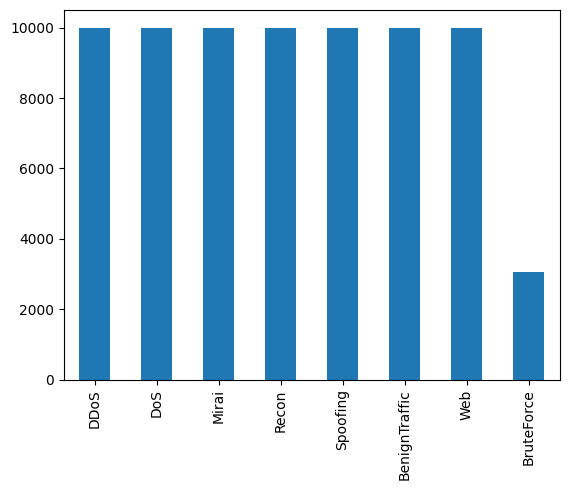

In [13]:
df_test_final.category_label.value_counts().plot(kind='bar')

<h1> NON-LINEAR CLASSIFIERS </h1>

### Helper Function

In [14]:
def plot_metric(eval_dict, model_name, param_name, param_values, log_scale=False):
    fig, ax = plt.subplots(3, 2, figsize=(12, 8), sharex=True)

    metrics = {
        'Accuracy': 'list_accuracy',
        'Precision': 'list_precision',
        'Recall': 'list_recall',
        'Specificity': 'list_specificity',
        'F1': 'list_f1',
        'Training time': 'list_training_time'
    }

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:olive', 'tab:cyan', 'tab:red']

    for i, (metric_name, metric_key) in enumerate(metrics.items()):
        x_value = list(range(0, len(eval_dict[metric_key])))
        ax[i // 2, i % 2].plot(x_value, eval_dict[metric_key], c=colors[i])
        if log_scale:
            ax[i // 2, i % 2].set_xscale('log')
        
        # Add xticks at the position of the maximum value
        max_idx = np.argmax(eval_dict[metric_key])
        max_value = eval_dict[metric_key][max_idx]
        ax[i // 2, i % 2].axvline(x=x_value[max_idx], color='lightgray', linestyle='--')
        ax[i // 2, i % 2].axhline(y=max_value, color='lightgray', linestyle='--')
        ax[i // 2, i % 2].scatter(x_value[max_idx], max_value, color='red', marker='o')
        ax[i // 2, i % 2].set_xticks(ticks=x_value, labels=param_values, rotation=90)
        
        ax[i // 2, i % 2].set_title(f'{metric_name} ({model_name})')
        ax[i // 2, i % 2].set_xlabel(param_name)
        
        # Add y-axis label (tick) for the maximum value
        ax[i // 2, i % 2].set_ylabel(metric_name)
        yticks = list(ax[i // 2, i % 2].get_yticks())
        del yticks[-2:]
        yticks.append(max_value)
        ax[i // 2, i % 2].set_yticks(yticks)
        if metric_name != 'Training time':
            ax[i // 2, i % 2].text(max_idx, eval_dict[metric_key][np.argmin(eval_dict[metric_key])], f'{param_values[max_idx]}', c='red')
        
    plt.tight_layout()
    plt.show()


<h2> k-Nearest-Neighbors </h2>

Now let's create the list of parameters for k-Nearest-Neighbors and a list for each metrics: we will evaluate them for each parameter in the list. In this case, we have chosen to do from 1 to 50 neighbors because the dataset is big, so we could try more neighbors than just 5 having good perfomances. Then, we will plot and analyze the metrics.

In [16]:
list_param_k_nearest_neighbors = range(1,50)

In [17]:
eval_dict = {'list_accuracy': [], 
             'list_precision': [], 
             'list_recall': [], 
             'list_specificity': [], 
             'list_f1': [], 
             'list_training_time': []}

In [18]:
# Initialize variables to keep track of the best model
best_accuracy = 0.0

for val in list_param_k_nearest_neighbors:
    # Create classifier instance
    clf = KNeighborsClassifier(n_neighbors=val, )
    
    # Register start time
    t_start = time.time()
    
    # Fit the classifier on the training data
    clf.fit(X_train, y_train)
    
    # Register end time
    t_stop = time.time()
    
    # Predict probabilities on the test data
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    current_accuracy = accuracy_score(y_test, y_pred)
    
    # Save the model if it has the best accuracy so far
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        dump(clf, 'models/nonLinear/knn_best.joblib')

    eval_dict['list_accuracy'].append(current_accuracy)
    eval_dict['list_precision'].append(precision_score(y_test, y_pred, average='weighted'))
    eval_dict['list_recall'].append(recall_score(y_test, y_pred, average='weighted'))
    eval_dict['list_specificity'].append(recall_score(y_test, y_pred, pos_label=0, average='weighted'))
    eval_dict['list_f1'].append(f1_score(y_test, y_pred, average='weighted'))
    eval_dict['list_training_time'].append(t_stop - t_start)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average

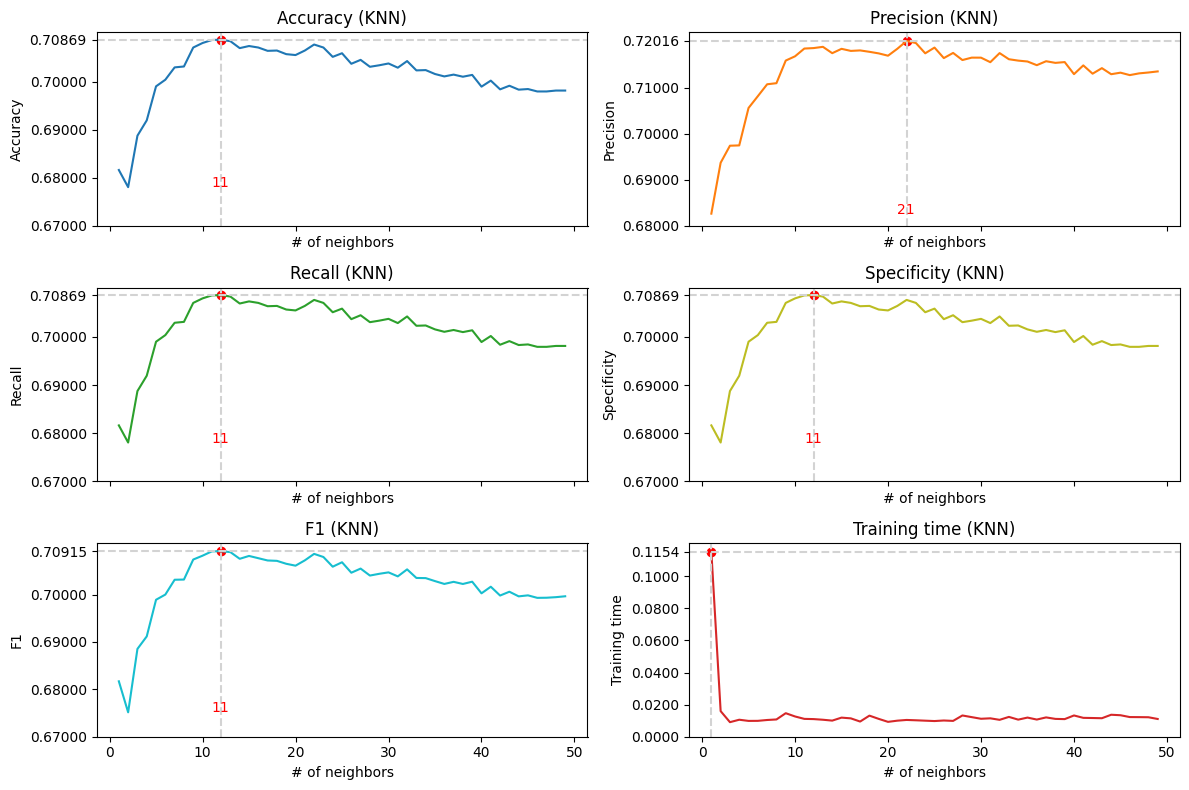

In [20]:
plot_metric(eval_dict, 'KNN', '# of neighbors', list_param_k_nearest_neighbors)

As we can see from the metrics, for the number of neighbors between 1 and 11 (21 for precision) the scores of the metrics start to grow, but from 11 (21 for precision) it decreases; This is because analyzing too many neighbors at once could result in underfitting- the association of wrong labels (for the property of the algorithm). Also, we had the greatest time performances with kNN: this is because it does not do anything complicated, it just needs to calculate the distances between point in the n-dimension space and K neighbors, so these are very basic actions to perform for the machine.

let's now load the best (k = 11) model and analyze the confusion matrix for this model

In [19]:
clf = load('models/nonLinear/knn_best.joblib')
y_pred = clf.predict(X_test_final)

In [28]:
print(classification_report(y_test_final, y_pred,target_names=label2id))

               precision    recall  f1-score   support

BenignTraffic       0.63      0.72      0.67     10000
        Mirai       1.00      0.97      0.99     10000
         DDoS       0.84      0.86      0.85     10000
     Spoofing       0.70      0.58      0.63     10000
          Web       0.57      0.63      0.60     10000
        Recon       0.78      0.52      0.63     10000
   BruteForce       0.30      0.54      0.38      3064
          DoS       0.80      0.82      0.81     10000

     accuracy                           0.72     73064
    macro avg       0.70      0.71      0.70     73064
 weighted avg       0.74      0.72      0.73     73064



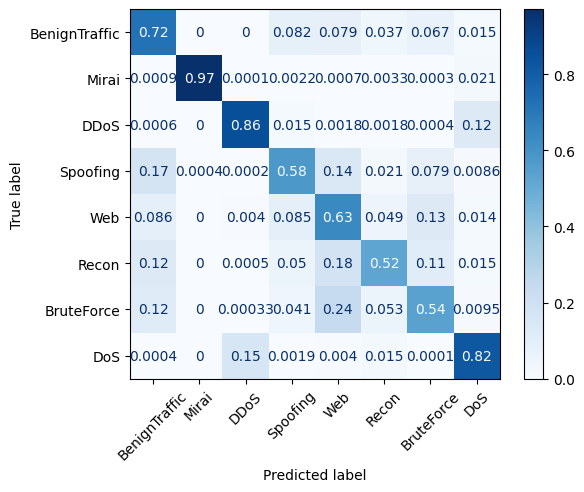

In [29]:
ConfusionMatrixDisplay.from_predictions(y_test_final, y_pred, display_labels=label2id, cmap='Blues', normalize='true', xticks_rotation=45)
plt.show()

<h2> Decision Tree </h2>

Now we will try with Decision Tree.Let's create the list of parameters for Decision Tree classifier and a list for each metrics: we will evaluate them for each parameter in the list. In this case, we have chosen to do from 3 to 200 as a max_depth, and a step of 5 to look at the behaviour of Decision Tree classifier based on how much it can increase its perfomance with the increasing of the max_depth we want to reach. Then, we will plot and analyze the metrics.

In [15]:
list_param_decision_tree = range(3, 200, 5)

In [16]:
eval_dict = {'list_accuracy': [], 
             'list_precision': [], 
             'list_recall': [], 
             'list_specificity': [], 
             'list_f1': [], 
             'list_training_time': []}

In [17]:
# Initialize variables to keep track of the best model
best_accuracy = 0.0

for val in list_param_decision_tree:
    # Create classifier instance
    clf = DecisionTreeClassifier(max_depth=val, random_state=777)
    
    # Register start time
    t_start = time.time()
    
    # Fit the classifier on the training data
    clf.fit(X_train, y_train)
    
    # Register end time
    t_stop = time.time()
    
    # Predict probabilities on the test data
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    current_accuracy = accuracy_score(y_test, y_pred)
    
    # Save the model if it has the best accuracy so far
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        dump(clf, 'models/nonLinear/DT_best.joblib')

    eval_dict['list_accuracy'].append(current_accuracy)
    eval_dict['list_precision'].append(precision_score(y_test, y_pred, average='weighted'))
    eval_dict['list_recall'].append(recall_score(y_test, y_pred, average='weighted'))
    eval_dict['list_specificity'].append(recall_score(y_test, y_pred, pos_label=0, average='weighted'))
    eval_dict['list_f1'].append(f1_score(y_test, y_pred, average='weighted'))
    eval_dict['list_training_time'].append(t_stop - t_start)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3

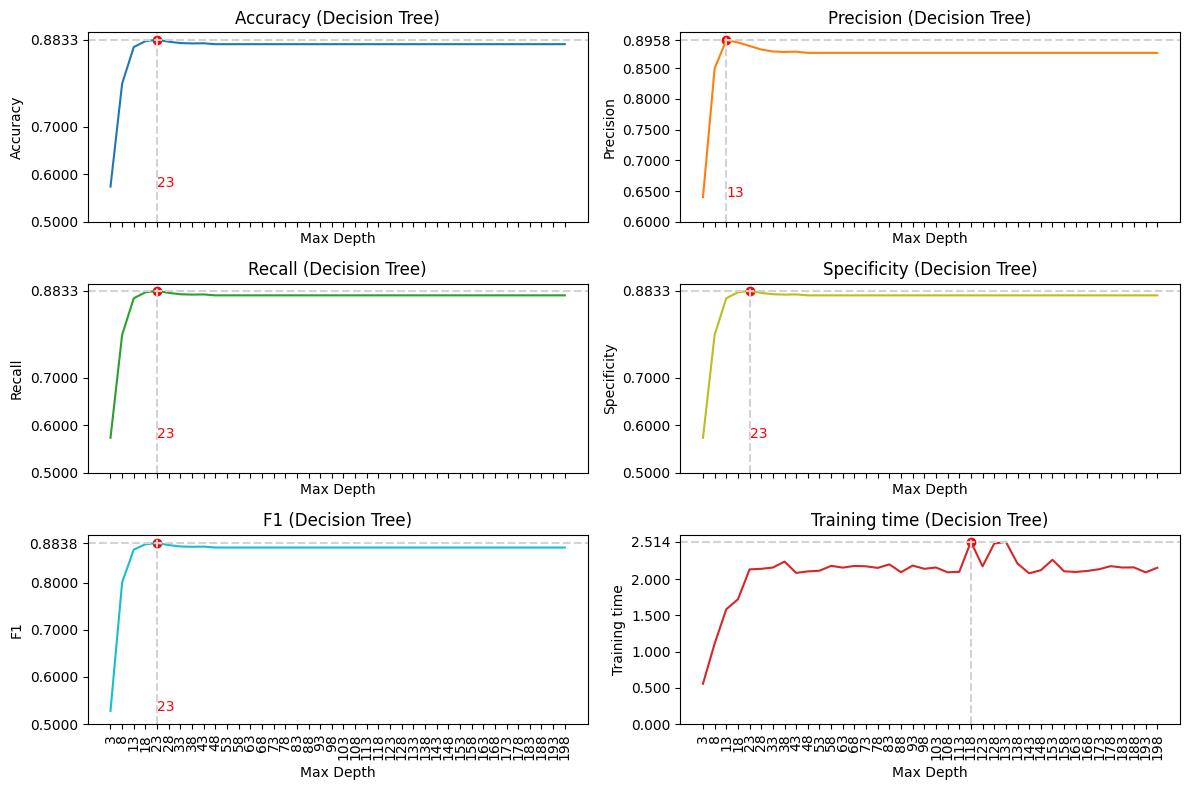

In [18]:
plot_metric(eval_dict, 'Decision Tree', 'Max Depth', list_param_decision_tree)

As we can see from the plots, from around a max_depth of 23-25 the metrics are converging. In this case, another important metric to consider is time: note that the greater the max_depth we want to reach, greater will be the peaks of the time. It's much faster than other classifiers because Decison Trees work well on large datasets. Other than time perfomances, we had a higher accuracy, precision, recall, specificity and f1 values than the other classifiers: this is because Decision Trees work in general very well on multi labelled dataset.

let's now load the best (max_depth = 23) model and analyze the confusion matrix for this model

In [35]:
clf = load('models/nonLinear/DT_best.joblib')
y_pred = clf.predict(X_test_final)

In [36]:
print(classification_report(y_test_final, y_pred, target_names=label2id))

               precision    recall  f1-score   support

BenignTraffic       0.86      0.85      0.86     10000
        Mirai       1.00      0.98      0.99     10000
         DDoS       1.00      0.96      0.98     10000
     Spoofing       0.84      0.81      0.83     10000
          Web       0.76      0.86      0.80     10000
        Recon       0.86      0.77      0.81     10000
   BruteForce       0.59      0.77      0.67      3064
          DoS       1.00      0.98      0.99     10000

     accuracy                           0.88     73064
    macro avg       0.86      0.87      0.86     73064
 weighted avg       0.89      0.88      0.88     73064



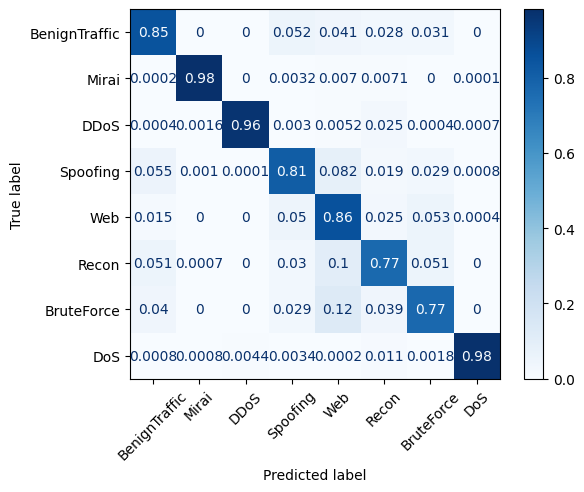

In [37]:
ConfusionMatrixDisplay.from_predictions(y_test_final, y_pred, display_labels=label2id, cmap='Blues', normalize='true', xticks_rotation=45)
plt.show()

As seen above, the label-based performance is significantly better than the other models. 

<h3> Kernel Support Vector Machines </h3>

Now we will try with Kernel Support Vector Machines.Let's create the list of parameters for Kernel Support Vector Machines classifier and a list for each metrics: we will evaluate them for each parameter in the list. In this case, we have chosen to work on the C parameter (regularization parameter) to look at the behaviour of Kernel Support Vector Machines classifier.Then, we will plot and analyze the metrics.

In [29]:
list_param_kernel_support_vector_machines = [0.1, 0.5, 1.0, 2.5, 5.0]

In [30]:
eval_dict = {'list_accuracy': [],
            'list_precision': [],
            'list_recall': [],
            'list_specificity': [],
            'list_f1': [],
            'list_training_time': []}

In [31]:
# Initialize variables to keep track of the best model
best_accuracy = 0.0

for val in list_param_kernel_support_vector_machines:
    # Create classifier instance
    clf = SVC(C=val, random_state=777)
    
    # Register start time
    t_start = time.time()
    
    # Fit the classifier on the training data
    clf.fit(X_train, y_train)
    
    # Register end time
    t_stop = time.time()
    
    # Predict probabilities on the test data
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    current_accuracy = accuracy_score(y_test, y_pred)
    
    # Save the model if it has the best accuracy so far
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        dump(clf, 'models/nonLinear/kernel_SVM_best.joblib')

    eval_dict['list_accuracy'].append(current_accuracy)
    eval_dict['list_precision'].append(precision_score(y_test, y_pred, average='weighted'))
    eval_dict['list_recall'].append(recall_score(y_test, y_pred, average='weighted'))
    eval_dict['list_specificity'].append(recall_score(y_test, y_pred, pos_label=0, average='weighted'))
    eval_dict['list_f1'].append(f1_score(y_test, y_pred, average='weighted'))
    eval_dict['list_training_time'].append(t_stop - t_start)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_cl

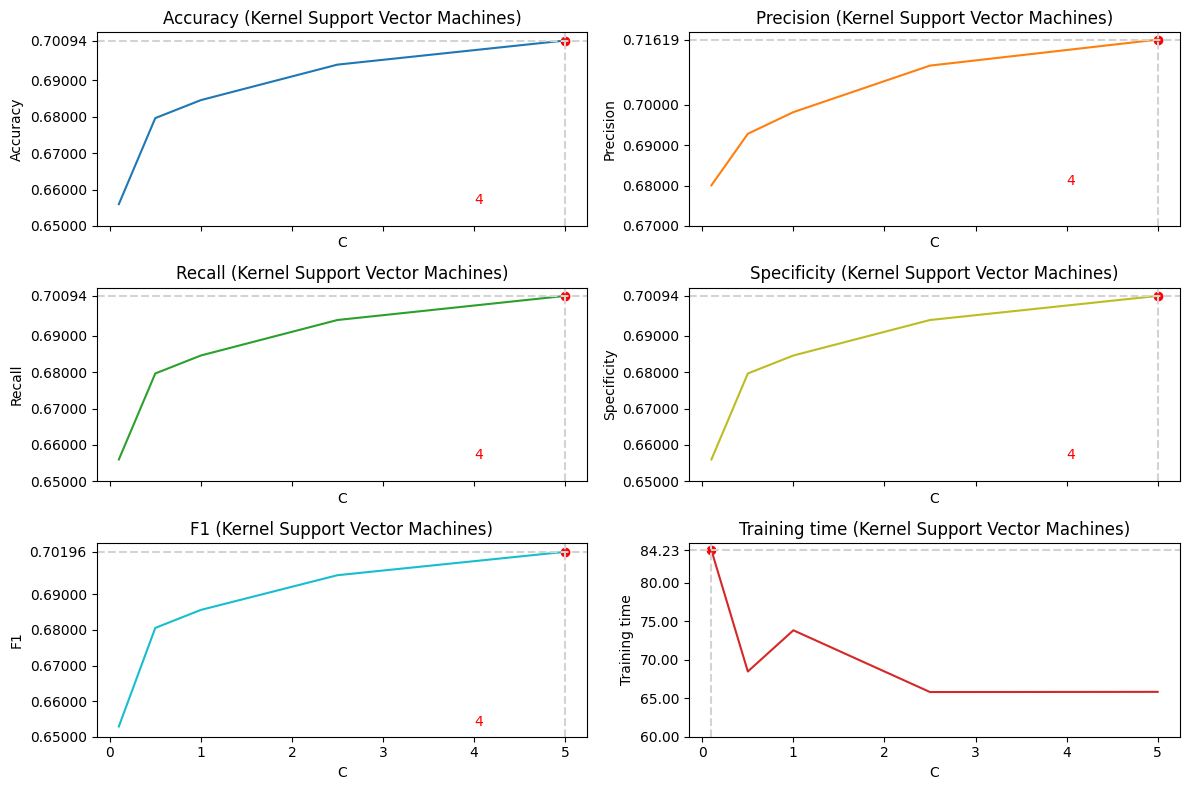

In [32]:
plot_metric(eval_dict, 'Kernel Support Vector Machines', 'C', list_param_kernel_support_vector_machines)

As we can see, Kernel SVM is a very slow non linear classifier for this dataset: this is because we are working on a relatively large dataset, and we know that complexity of training kernelized SVM grows quadratically with number of training samples. The general trend of performance remains the same: as C increases, the performance increases. 

let's now load the best (C=) model and analyze the confusion matrix for this model

In [38]:
clf = load('models/nonLinear/kernel_SVM_best.joblib')
y_pred = clf.predict(X_test_final)

It takes quite long to predict (4 min)

In [41]:
print(classification_report(y_test_final, y_pred,target_names=label2id))

               precision    recall  f1-score   support

BenignTraffic       0.73      0.74      0.74     10000
        Mirai       1.00      0.97      0.98     10000
         DDoS       0.76      0.72      0.74     10000
     Spoofing       0.66      0.63      0.65     10000
          Web       0.59      0.72      0.65     10000
        Recon       0.85      0.51      0.64     10000
   BruteForce       0.30      0.60      0.40      3064
          DoS       0.76      0.75      0.75     10000

     accuracy                           0.72     73064
    macro avg       0.71      0.71      0.69     73064
 weighted avg       0.74      0.72      0.72     73064



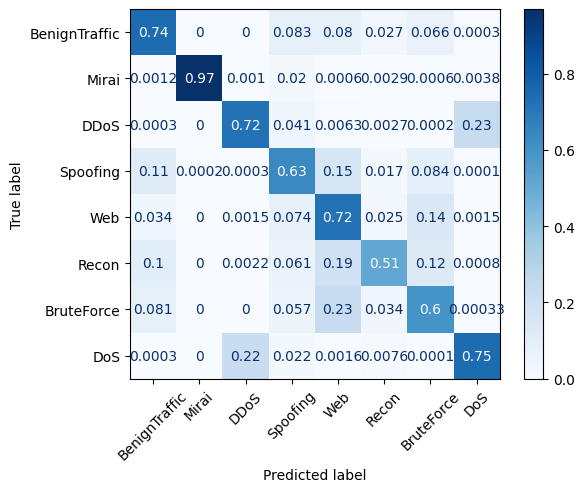

In [42]:
ConfusionMatrixDisplay.from_predictions(y_test_final, y_pred, display_labels=label2id, cmap='Blues', normalize='true', xticks_rotation=45)
plt.show()

<h3> Neural Networks </h3>

Now we will try with Neural Networks. In this case, the parameter under consideration is the number of hidden layers to look at the behaviour of the NN classifier. Then, we will plot and analyze the metrics.
We chose to keep a low number of perceptrons within each layer in order to maintain time efficiency and also considering the size and complexity of our dataset.

In [87]:
list_param_neural_networks = [(10),(50),(50, 10),(50, 50),(100, 50, 10)]

In [88]:
eval_dict = {'list_accuracy': [],
            'list_precision': [],
            'list_recall': [],
            'list_specificity': [],
            'list_f1': [],
            'list_training_time': []}

In this case, the default number of iterations (200) was not sufficient to make the optimization converge, so we needed to increase it.

In [89]:
# Initialize variables to keep track of the best model
best_accuracy = 0.0

for val in list_param_neural_networks:
    # Create classifier instance
    clf = MLPClassifier(hidden_layer_sizes=val, max_iter=2000, random_state=777, early_stopping=True, n_iter_no_change=100)
    
    # Register start time
    t_start = time.time()
    
    # Fit the classifier on the training data
    clf.fit(X_train, y_train)
    
    # Register end time
    t_stop = time.time()
    
    # Predict probabilities on the test data
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    current_accuracy = accuracy_score(y_test, y_pred)
    
    # Save the model if it has the best accuracy so far
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        dump(clf, 'models/nonLinear/NN_best.joblib')

    eval_dict['list_accuracy'].append(current_accuracy)
    eval_dict['list_precision'].append(precision_score(y_test, y_pred, average='weighted'))
    eval_dict['list_recall'].append(recall_score(y_test, y_pred, average='weighted'))
    eval_dict['list_specificity'].append(recall_score(y_test, y_pred, pos_label=0, average='weighted'))
    eval_dict['list_f1'].append(f1_score(y_test, y_pred, average='weighted'))
    eval_dict['list_training_time'].append(t_stop - t_start)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_cl

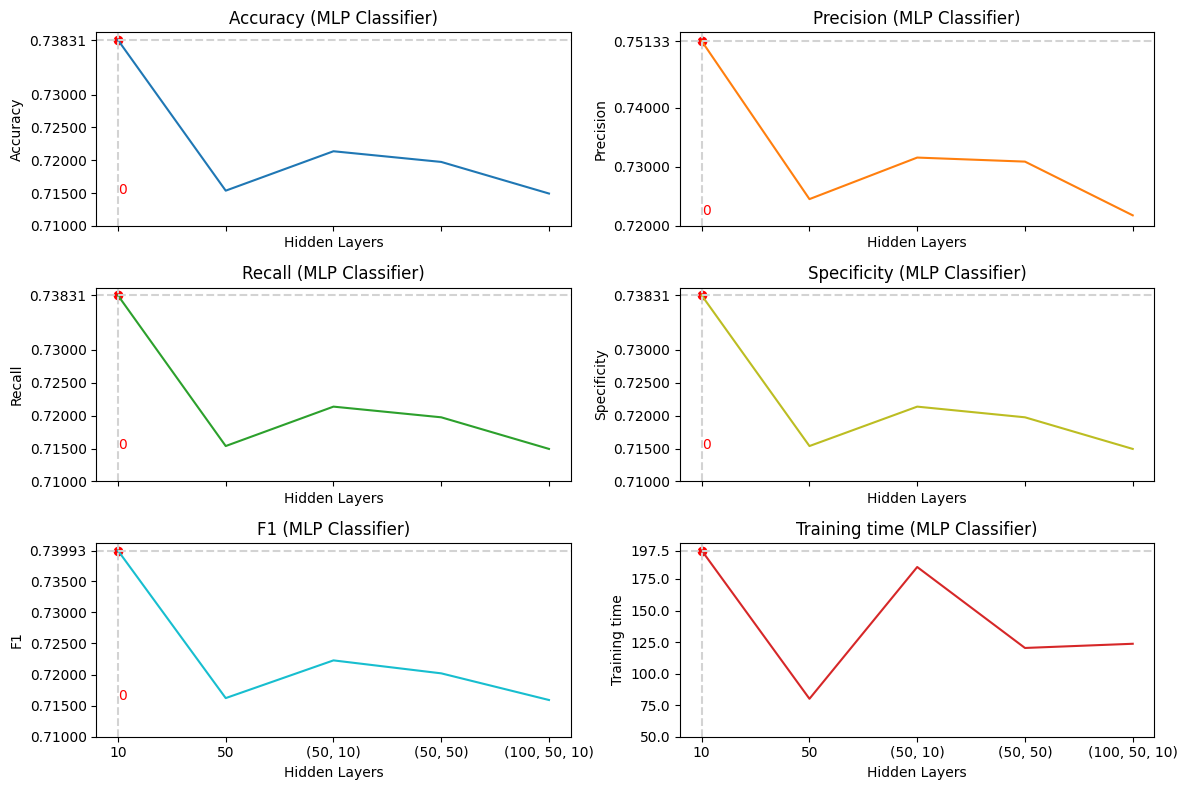

In [144]:
plot_metric(eval_dict, 'MLP Classifier', 'Hidden Layers', list_param_neural_networks)

A we can see, the time increases when the hidden layer size is greater (obviously, because this means that it has to pass through more layers). The peaks for the other metrics seems to be around the range of 150-200 hidden layers, then values start to decrease despite the number of hidden layers increase.

One of the possible explanations for this performance is because the neural network with more layers "overfits" the training data and performs worse on test data as a result. A neural network with less layers tends to generalize more, and therefore may make more sense considering the low complexity of our data.

let's now load the best (hidden_layer = ) model and analyze the confusion matrix for this model

In [43]:
clf = load('models/nonLinear/NN_best.joblib')
y_pred = clf.predict(X_test_final)

In [44]:
print(classification_report(y_test_final, y_pred,target_names=label2id))

               precision    recall  f1-score   support

BenignTraffic       0.73      0.75      0.74     10000
        Mirai       1.00      0.96      0.98     10000
         DDoS       0.93      0.91      0.92     10000
     Spoofing       0.75      0.63      0.68     10000
          Web       0.57      0.69      0.63     10000
        Recon       0.73      0.50      0.59     10000
   BruteForce       0.28      0.56      0.37      3064
          DoS       0.90      0.89      0.90     10000

     accuracy                           0.75     73064
    macro avg       0.74      0.74      0.73     73064
 weighted avg       0.78      0.75      0.76     73064



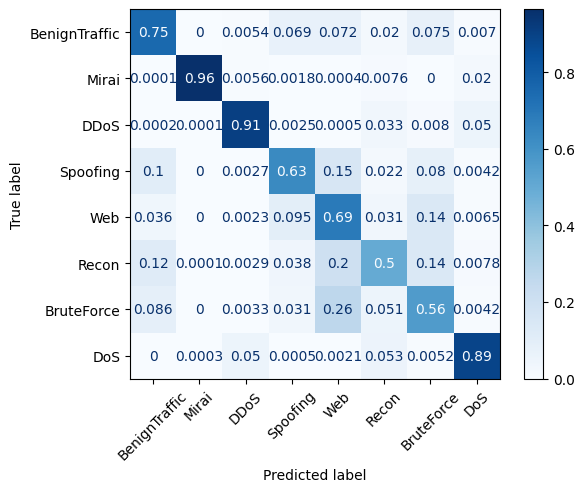

In [45]:
ConfusionMatrixDisplay.from_predictions(y_test_final, y_pred, display_labels=label2id, cmap='Blues', normalize='true', xticks_rotation=45)
plt.show()

## Conclusions

From our analysis, the decision tree model performs the best out of all the non-linear classifiers